In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from scipy.stats import spearmanr, rankdata
from joblib import Parallel, delayed
import warnings
import gc
import argparse
from tqdm.auto import tqdm
import glob
import matplotlib.pyplot as plt
import networkx as nx
import re
import sys


In [2]:
#Path to TwINFER code repository
path_to_code_repo = "/home/mzo5929/Keerthana/grnInference/code/TwINFER/"
sys.path.append(path_to_code_repo)

In [3]:
# Calculation functions
import importlib
from TwINFER_function_scripts import correlation_analysis_functions
from TwINFER_function_scripts import correlation_analysis_helpers

importlib.reload(correlation_analysis_functions)
importlib.reload(correlation_analysis_helpers)

from TwINFER_function_scripts.correlation_analysis_functions import (
    
    calculate_pairwise_gene_gene_correlation_matrix,
    check_system_in_steady_state,
    check_gene_gene_correlation_threshold,
    calculate_twin_random_pair_correlations,
    differentiate_single_state_reg_and_multiple_states,
    identify_reg_if_multiple_states,
)

# Helper functions
from TwINFER_function_scripts.correlation_analysis_helpers import (
    read_input_matrix,
)


In [4]:
def generate_random_shuffle(simulation_data, gene_list, n_shuffles=10000, random_state=42):
    """
    Generate exactly 10k different random shuffles with maximum vectorization.
    """
    np.random.seed(random_state)
    
    rep_0 = simulation_data[simulation_data['replicate'] == 1].reset_index(drop=True)
    rep_1 = simulation_data[simulation_data['replicate'] == 2].reset_index(drop=True)
    print(rep_0.shape, rep_1.shape)
    gene_cols = [f"{gene}_mRNA" for gene in gene_list]
    min_cells = min(len(rep_0), len(rep_1))
    expr_0 = rep_0[gene_cols].iloc[:min_cells].values
    expr_1 = rep_1[gene_cols].iloc[:min_cells].values

    
    n_cells, n_genes = expr_0.shape
    
    # Pre-generate ALL shuffle indices at once
    all_shuffle_indices = np.array([np.random.permutation(n_cells) for _ in range(n_shuffles)])
    
    # Vectorized processing in batches to manage memory
    batch_size = 100  # Process 100 shuffles at a time
    all_correlations = []
    
    for batch_start in range(0, n_shuffles, batch_size):
        batch_end = min(batch_start + batch_size, n_shuffles)
        batch_indices = all_shuffle_indices[batch_start:batch_end]
        
        # Vectorized batch processing
        batch_correlations = []
        
        for shuffle_idx in batch_indices:
            # Single shuffle
            expr_1_shuffled = expr_1[shuffle_idx]
            deltas = expr_0 - expr_1_shuffled
            
            # Vectorized correlation matrix
            ranked_deltas = np.apply_along_axis(rankdata, 0, deltas)
            corr_matrix = np.corrcoef(ranked_deltas.T)
            
            # Store only upper triangle to save memory
            triu_indices = np.triu_indices(n_genes, k=1)
            batch_correlations.append(corr_matrix[triu_indices])
        
        all_correlations.extend(batch_correlations)
    
    # Convert to numpy array for efficient statistics
    all_correlations = np.array(all_correlations)  # Shape: (10000, n_gene_pairs)
    
    # Calculate comprehensive statistics
    random_stats = {
        'all_values': all_correlations.flatten(),
        'mean_per_pair': np.mean(all_correlations, axis=0),
        'std_per_pair': np.std(all_correlations, axis=0),
        'percentile_95': np.percentile(np.abs(all_correlations.flatten()), 95),
        'percentile_100': np.percentile(np.abs(all_correlations.flatten()), 100),
        'global_mean': np.mean(all_correlations),
        'global_std': np.std(all_correlations)
    }
    
    return random_stats

In [5]:
def split_and_merge_simulations(path_to_simulation_file):
    """Split clone IDs evenly between two simulations and merge them."""
    
    simulation_1 = pd.read_csv(path_to_simulation_file[0])
    simulation_2 = pd.read_csv(path_to_simulation_file[1])
    
    # Get unique clone IDs and split in half
    clone_ids = sorted(simulation_1['clone_id'].unique())
    half_point = len(clone_ids) // 2
    
    clones_from_sim1 = clone_ids[:half_point]
    clones_from_sim2 = clone_ids[half_point:]
    
    # Filter and merge
    sim1_subset = simulation_1[simulation_1['clone_id'].isin(clones_from_sim1)]
    sim2_subset = simulation_2[simulation_2['clone_id'].isin(clones_from_sim2)]
    merged_df = pd.concat([sim1_subset, sim2_subset], ignore_index=True)
    return merged_df

def infer_using_twinfer(path_to_simulation_file, base_config, t1, t2, 
                        threshold_gene_gene_corr=0.04,
                        check_for_steady_state=True, 
                        plot_correlation_matrices_as_heatmap=True,
                        have_any_output=True,
                        seed = 100):
    """
    Infer gene regulatory interactions from simulated or experimental twin-cell data
    using the TwINFer pipeline.

    This function processes a single simulation (or equivalent experimental dataset)
    to:
      1. Check system steady state at an early timepoint.
      2. Compute gene–gene correlations at early and late timepoints.
      3. Classify candidate regulations as single-state or multiple-state.
      4. Infer directionality of single-state interactions from across-time twin pairs.
      5. Optionally visualize intermediate matrices and the inferred network.

    The approach uses twin cell pairs (descended from the same mother cell) and 
    compares their gene expression correlations at early and late post-division 
    times, as well as across-time twin measurements, to determine regulation type 
    and directionality.

    Parameters
    ----------
    path_to_simulation_file : str
        Path to the CSV file containing simulation or experimental output.
        The file should have one row per cell per timepoint, with at least:
        - 'clone_id': integer clone identifier.
        - 'cell_id': unique cell identifier.
        - 'time_step': time (in hours) post-division.
        - gene expression columns for each gene.

    base_config : dict
        Dictionary specifying simulation metadata and parameter sources:
            - "n_cells" : int
                Expected number of twin clones.
            - "twin_simulation_time_after_division" : int or float
                Duration after division covered in the simulation (hours).
            - "twin_measurement_resolution" : int or float
                Sampling resolution (hours).
            - "path_to_connectivity_matrix" : str
                File path to the interaction (connectivity) matrix.
            - "param_csv" : str
                File path to the parameter CSV file.
            - "rows_to_use" : list[list[int]]
                Parameter row indices corresponding to this simulation.

    t1 : int or float
        Early timepoint (hours) used for initial gene–gene correlation analysis.

    t2 : int or float
        Late timepoint (hours) used for twin vs random correlation comparison and 
        across-time directionality inference.

    threshold_gene_gene_corr : float, default=0.04
        Absolute correlation threshold above which gene–gene pairs are considered
        potential regulations.

    check_for_steady_state : bool, default=True
        If True, verifies that the system is in steady state at t1 using a mean and 
        slope threshold; raises ValueError if not steady.

    plot_correlation_matrices_as_heatmap : bool, default=True
        If True, generates heatmaps for:
            - Gene–gene correlations at t1
            - Twin and random correlations at t2
            - Directionality matrix

    have_any_output : bool, default=True
        If True, prints a summary of inferred regulations and shows network plots.

    Returns
    -------
    dict
        Dictionary containing:
            - "direction_matrix" : pd.DataFrame
                Normalized directional correlation matrix (t1 → t2) for single-state regulations.
            - "direction_raw_matrix" : pd.DataFrame
                Raw directional correlation differences without thresholding.
            - "pairwise_gene_gene_correlation_matrix" : pd.DataFrame
                Gene–gene Spearman correlation matrix at t1.
            - "twin_pair_correlation_matrix_t2" : pd.DataFrame
                Twin-cell correlation matrix at t2.
            - "random_pair_correlation_matrix_t2" : pd.DataFrame
                Random-cell correlation matrix at t2.
            - "twin_pair_correlation_matrix_t1" : pd.DataFrame
                Twin-cell correlation matrix at t1.
            - "random_pair_correlation_matrix_t1" : pd.DataFrame
                Random-cell correlation matrix at t1.

    Raises
    ------
    AssertionError
        If the number of clones or sampled timepoints in the simulation file does 
        not match `base_config`.
    ValueError
        If required timepoints t1 or t2 are missing from the data.
        If steady state is required and not reached.

    Notes
    -----
    - Clones are split into three disjoint sets for t1-only, t2-only, and across-time
      measurements in a 1:1:2 ratio.
    - Gene-gene and random-pair correlations uses all cell measurements at both time t1 and t2.
    - Across-time twin pairs are sampled by selecting one cell per clone at t1 and 
      one different cell at t2 from the same clone.
    - Single-state vs multiple-state regulation classification is based on the 
      difference between twin and random correlations at t2.
    - Directionality inference uses correlation differences between across-time 
      twin pairs at t1 and t2.
    """

    # Load simulation data
    try:
        if isinstance(path_to_simulation_file, str):
            simulation = pd.read_csv(path_to_simulation_file)
        if len(path_to_simulation_file) == 2:
            simulation = split_and_merge_simulations(path_to_simulation_file)
    except Exception as e:
        raise RuntimeError(f"Error reading the simulation file: {e}")

    # Load connectivity matrix and parameter set
    path_to_connectivity_matrix = base_config["path_to_connectivity_matrix"]
    path_to_parameter_csv = base_config["param_csv"]
    param_df = pd.read_csv(path_to_parameter_csv, index_col=0)

    # --- Basic sanity checks ---
    # Assert number of clones in simulation file matches config
    n_clones_simulation = simulation['clone_id'].nunique()
    print(n_clones_simulation)
    n_clones_base_config = base_config["n_cells"]
    # assert n_clones_simulation == n_clones_base_config, \
    #     "Number of twin pairs in the simulation file does not match n_cells in base_config."

    # Assert time points match expected resolution
    time_points_simulations = simulation['time_step'].unique()
    time_points_base_config = np.arange(
        0, 
        base_config['twin_simulation_time_after_division'] + base_config['twin_measurement_resolution'], 
        base_config['twin_measurement_resolution']
    )

    ## Load gene parameters and connectivity structure
    n_genes, interaction_matrix = read_input_matrix(path_to_connectivity_matrix)
    gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

    # Ensure the time points t1 and t2 exist in the simulation data
    unique_timepoints = simulation['time_step'].unique()

    if t1 not in unique_timepoints:
        raise ValueError(f"Time point t1={t1} not found in simulation['time_step'].")
    if t2 not in unique_timepoints:
        raise ValueError(f"Time point t2={t2} not found in simulation['time_step'].")

    # Subset the simulation at the desired timepoints

    # Shuffle all clone IDs
    np.random.seed(seed)
    clone_ids_shuffled = np.random.permutation(n_clones_simulation)

    # Split into 1:1:2 ratio
    n1 = n2 = n_clones_simulation // 4
    t1_clones = clone_ids_shuffled[:n1]
    t2_clones = clone_ids_shuffled[n1:n1+n2]
    across_t_clones = clone_ids_shuffled[n1+n2:]

    # Subset directly
    t1_twins = simulation[(simulation['clone_id'].isin(t1_clones)) & (simulation['time_step'] == t1)]
    t2_twins = simulation[simulation['clone_id'].isin(t2_clones) & (simulation['time_step'] == t2)]
    print(f"t1_twins: {t1_twins.shape}")
    print(f"t2_twins: {t2_twins.shape}")

    # Across_t: pick exactly one random twin per clone_id
    # One cell per clone at t1
    across_t_twin1 = simulation[(simulation['clone_id'].isin(across_t_clones)) & (simulation['time_step'] == t1) & (simulation['replicate'] == 1)]
    across_t_twin2 = simulation[(simulation['clone_id'].isin(across_t_clones)) & (simulation['time_step'] == t2) & (simulation['replicate'] == 2)]

    # Reset index for cleanliness
    t1_twins = t1_twins.reset_index(drop=True)
    t2_twins = t2_twins.reset_index(drop=True)
    across_t_twin1 = across_t_twin1.reset_index(drop=True)
    across_t_twin2 = across_t_twin2.reset_index(drop=True)

    all_t1_t2_measurements = pd.concat(
    [t1_twins, t2_twins, across_t_twin1, across_t_twin2],
    ignore_index=True
    )
    
    # --- Step 1: Pairwise gene-gene correlations at t1 ---
    pairwise_gene_gene_correlation_matrix = calculate_pairwise_gene_gene_correlation_matrix(
        all_t1_t2_measurements, gene_list
    )
    no_regulation, potential_regulation, threshold_used = check_gene_gene_correlation_threshold(
        all_t1_t2_measurements, pairwise_gene_gene_correlation_matrix, gene_list,  threshold = threshold_gene_gene_corr, use_scramble = True, verbose = False
    )
                                          
    # print(no_regulation)
    if plot_correlation_matrices_as_heatmap:
        plot_matrix_as_heatmap(corr_matrix=pairwise_gene_gene_correlation_matrix, gene_list=gene_list, no_regulation=no_regulation, potential_regulation=potential_regulation,
            title=f"Gene-gene correlations across both timepoints", add_gene_labels=True, add_time=False, gray_out_no_reg=False
        )

    # --- Step 2: Twin/random correlations at t2 ---
    twin_pair_correlation_matrix_t2, random_pair_correlation_matrix_t2 = calculate_twin_random_pair_correlations(
        all_t1_t2_measurements, t2_twins, gene_list
    )
    # print(twin_pair_correlation_matrix_t2)
    if plot_correlation_matrices_as_heatmap:
        plot_matrix_as_heatmap( corr_matrix=twin_pair_correlation_matrix_t2, gene_list=gene_list, no_regulation=no_regulation, potential_regulation=potential_regulation,
            title=f"Twin pair correlations at time {t2}h", add_gene_labels=True, add_time=True, time=[t2], gray_out_no_reg=True
        )
        
        plot_matrix_as_heatmap( corr_matrix=random_pair_correlation_matrix_t2, gene_list=gene_list, no_regulation=no_regulation, potential_regulation=potential_regulation,
            title=f"Random pair correlations across both time points", add_gene_labels=True, add_time=False, time=[t2], gray_out_no_reg=True
        )

    t2_twin_corr = twin_pair_correlation_matrix_t2.loc['gene_1', 'gene_2']
    # --- Step 3: Classify regulation type: single-state vs multiple-states ---
    multiple_states_gene_pairs, single_state_regulation = differentiate_single_state_reg_and_multiple_states(
        potential_regulation, twin_pair_correlation_matrix_t2, random_pair_correlation_matrix_t2, gene_list
    )
    twin_pair_correlation_matrix_t1, random_pair_correlation_matrix_t1 = calculate_twin_random_pair_correlations(
                all_t1_t2_measurements, t1_twins, gene_list
            )
    if len(multiple_states_gene_pairs) > 0:
        multiple_states_no_reg, multiple_states_and_reg = identify_reg_if_multiple_states(
            twin_pair_correlation_matrix_t1,twin_pair_correlation_matrix_t2,random_pair_correlation_matrix_t1,
            random_pair_correlation_matrix_t2,multiple_states_gene_pairs,gene_list
            )
    else:
        multiple_states_no_reg, multiple_states_and_reg = [], []

    return {
        "pairwise_gene_gene_correlation_matrix": pairwise_gene_gene_correlation_matrix,
        "twin_pair_correlation_matrix_t2": twin_pair_correlation_matrix_t2,
        "random_pair_correlation_matrix_t2": random_pair_correlation_matrix_t2,
        "twin_pair_correlation_matrix_t1": twin_pair_correlation_matrix_t1,
        "random_pair_correlation_matrix_t1": random_pair_correlation_matrix_t1,
        "gene_gene_correlation_threshold": threshold_used
    }

In [18]:
#Common path to data files
path_to_data = f"{path_to_code_repo}/simulation_example_input_data"
base_config = {
    'n_cells': 6000, #Number of cells before division (number of twin pairs)
    'simulation_time_before_division': 1000, #The time used to run the initial cells before division. User must set this time to ensure the population reaches steady state [hours]
    'twin_simulation_time_after_division': 48, #The time twin cells are simulated after division and measurements are stored in the output[hours]
    'twin_measurement_resolution': 1, #The time between each measurement of twin cells [hours]. For example, if twin_sampling_duration is 12 and twin_measurement_resolution is 1, the final dataframe will contain hourly measurements for 12 hours (0 is birth).
    "path_to_connectivity_matrix": f"{path_to_data}/connectivity_matrix_A_to_B.txt", #path to the connectivity matrix specifying the GRN to simulate
    "param_csv": f"{path_to_data}/median_parameter.csv", #Path to the parameters for all genes and interaction terms
    "rows_to_use": [[0,0]], #Rows in the parameter's csv file for each gene - the length should be equal to number of genes in the system. Example - [0,0] will mean use row 0 parameters for both gene 1 and 2
    "output_folder": f"{path_to_code_repo}/example_simulation_output/", #Path to folder to store simulation 
    "log_file": f"{path_to_code_repo}/example_simulation_output/example_log.jsonl", #Path to the log file
    "type": "A_to_B",  # Name of the network used -- will be in the filename
    "number_of_parallel_parameters": 1, #Number of parameters to be run in parallel
    "number_of_cores_per_parameter": 10, #Number of cores to be used per parameter (number_of_parallel_parameters * number_of_cores_per_parameter = number of cores in your computer)
}

In [8]:
def get_many_random_pair_corr(path_to_simulation_file, base_config, t1, t2, 
                        threshold_gene_gene_corr=0.04,
                        check_for_steady_state=True, 
                        plot_correlation_matrices_as_heatmap=True,
                        have_any_output=True):

    # Load simulation data
    try:
        if isinstance(path_to_simulation_file, str):
            simulation = pd.read_csv(path_to_simulation_file)
        if len(path_to_simulation_file) == 2:
            simulation = split_and_merge_simulations(path_to_simulation_file)
    except Exception as e:
        raise RuntimeError(f"Error reading the simulation file: {e}")

    # Load connectivity matrix and parameter set
    path_to_connectivity_matrix = base_config["path_to_connectivity_matrix"]
    path_to_parameter_csv = base_config["param_csv"]
    param_df = pd.read_csv(path_to_parameter_csv, index_col=0)

    # --- Basic sanity checks ---
    # Assert number of clones in simulation file matches config
    n_clones_simulation = simulation['clone_id'].nunique()
    print(n_clones_simulation)
    n_clones_base_config = base_config["n_cells"]
    # assert n_clones_simulation == n_clones_base_config, \
    #     "Number of twin pairs in the simulation file does not match n_cells in base_config."

    # Assert time points match expected resolution
    time_points_simulations = simulation['time_step'].unique()
    time_points_base_config = np.arange(
        0, 
        base_config['twin_simulation_time_after_division'] + base_config['twin_measurement_resolution'], 
        base_config['twin_measurement_resolution']
    )

    # assert set(time_points_simulations) == set(time_points_base_config), \
    #     "The sampling time points in the simulation file do not match those specified in base_config."

    # Assert parameter row identity matches
    param_index_from_file_name = extract_param_index(path_to_simulation_file)
    param_index_from_base_config = "_".join(map(str, base_config["rows_to_use"][0]))
    # assert param_index_from_file_name == param_index_from_base_config, \
    #     "Simulation must match the details in base_config."

    # Load gene parameters and connectivity structure
    n_genes, interaction_matrix = read_input_matrix(path_to_connectivity_matrix)
    gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

    # Ensure the time points t1 and t2 exist in the simulation data
    unique_timepoints = simulation['time_step'].unique()

    if t1 not in unique_timepoints:
        raise ValueError(f"Time point t1={t1} not found in simulation['time_step'].")
    if t2 not in unique_timepoints:
        raise ValueError(f"Time point t2={t2} not found in simulation['time_step'].")

    # Subset the simulation at the desired timepoints

    # Shuffle all clone IDs
    clone_ids_shuffled = np.random.permutation(n_clones_simulation)

    # Split into 1:1:2 ratio
    n1 = n2 = n_clones_simulation // 4
    t1_clones = clone_ids_shuffled[:n1]
    t2_clones = clone_ids_shuffled[n1:n1+n2]
    across_t_clones = clone_ids_shuffled[n1+n2:]

    # Subset directly
    t1_twins = simulation[(simulation['clone_id'].isin(t1_clones)) & (simulation['time_step'] == t1)]
    t2_twins = simulation[simulation['clone_id'].isin(t2_clones) & (simulation['time_step'] == t2)]

    # Across_t: pick exactly one random twin per clone_id
    # One cell per clone at t1
    across_t_twin1 = simulation[(simulation['clone_id'].isin(across_t_clones)) & (simulation['time_step'] == t1) & (simulation['replicate'] == 1)]
    across_t_twin2 = simulation[(simulation['clone_id'].isin(across_t_clones)) & (simulation['time_step'] == t2) & (simulation['replicate'] == 2)]

    # Reset index for cleanliness
    t1_twins = t1_twins.reset_index(drop=True)
    t2_twins = t2_twins.reset_index(drop=True)
    across_t_twin1 = across_t_twin1.reset_index(drop=True)
    across_t_twin2 = across_t_twin2.reset_index(drop=True)

    all_t1_t2_measurements = pd.concat(
    [t1_twins, t2_twins, across_t_twin1, across_t_twin2],
    ignore_index=True
    )
    print(all_t1_t2_measurements.shape)
    scrambled_random_corr = generate_random_shuffle(all_t1_t2_measurements, gene_list, n_shuffles=10000, random_state=42)

    return scrambled_random_corr

In [9]:
def process_simulation(path_to_simulation_file, sim_type, rep_id, base_config, t1, t2, gene_names=None):
    """
    Process a simulation and return results with gene-pair columns.
    """
    if isinstance(path_to_simulation_file, list):
        fname = [os.path.basename(f) for f in path_to_simulation_file]
        print(f"Processing [{sim_type}]: {fname}")
    else:
        fname = os.path.basename(path_to_simulation_file)
        print(f"Processing [{sim_type}]: {fname}")

    results = infer_using_twinfer(
        path_to_simulation_file,
        base_config,
        t1, t2,
        check_for_steady_state=False,
        have_any_output=False,
        plot_correlation_matrices_as_heatmap=False
    )

    # Base metadata for this simulation
    record = {
        'sim_type': sim_type,
        'rep_id': rep_id,
        'analysis_key': f"{sim_type}_rep_{rep_id}",
        'gene_gene_threshold': results['gene_gene_correlation_threshold'],
        # 'random_corr_threshold': results['random_corr_threshold']
    }
    
    # Helper function to flatten matrix to gene-pair columns
    def matrix_to_gene_pair_columns(matrix, gene_names, prefix=""):
        """Convert matrix to dictionary with gene_pair column names."""
        columns = {}
        if matrix is not None:
            matrix_array = np.array(matrix)
            n_genes = len(gene_names) if gene_names else matrix_array.shape[0]
            
            # If gene_names not provided, use generic names
            if gene_names is None:
                gene_names = [f"g{i+1}" for i in range(n_genes)]
            
            for i in range(matrix_array.shape[0]):
                for j in range(matrix_array.shape[1]):
                    col_name = f"{prefix}{gene_names[i]}_{gene_names[j]}" if prefix else f"{gene_names[i]}_{gene_names[j]}"
                    columns[col_name] = matrix_array[i, j]
        
        return columns
    
    # Process all matrix types
    matrix_data = {
        'directional': results["direction_matrix"],
        'gene_gene': results["pairwise_gene_gene_correlation_matrix"],
        'random': results["random_pair_correlation_matrix_t2"],
        'twin_t1': results["twin_pair_correlation_matrix_t1"],
        'twin_t2': results["twin_pair_correlation_matrix_t2"]
    }
    
    # Add all matrix data as columns with prefixes
    for matrix_type, matrix in matrix_data.items():
        gene_pair_columns = matrix_to_gene_pair_columns(matrix, gene_names, f"{matrix_type}_")
        record.update(gene_pair_columns)
    
    return record

def save_results_to_csv(results_list, output_dir="results"):
    """Save results to CSV files."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Convert to DataFrame
    df = pd.DataFrame(results_list)
    
    # Save main results file
    main_file = os.path.join(output_dir, "all_simulation_results.csv")
    df.to_csv(main_file, index=False)
    print(f"✅ Saved all results to {main_file}")
    
    # Save separate files for each matrix type
    matrix_types = ['directional', 'gene_gene', 'random', 'twin_t1', 'twin_t2']
    
    for matrix_type in matrix_types:
        # Get columns for this matrix type
        matrix_columns = [col for col in df.columns if col.startswith(f"{matrix_type}_")]
        
        if matrix_columns:
            # Create subset with metadata + matrix columns
            metadata_cols = ['sim_type', 'rep_id', 'analysis_key', 'gene_gene_threshold']
            subset_cols = metadata_cols + matrix_columns
            subset_df = df[subset_cols].copy()
            
            # Remove prefix from column names for cleaner output
            rename_dict = {col: col.replace(f"{matrix_type}_", "") for col in matrix_columns}
            subset_df.rename(columns=rename_dict, inplace=True)
            
            # Save
            filename = os.path.join(output_dir, f"{matrix_type}_matrix_results.csv")
            subset_df.to_csv(filename, index=False)
            print(f"✅ Saved {matrix_type} matrix to {filename}")
    
    # Create summary by simulation type
    summary_data = []
    for sim_type in df['sim_type'].unique():
        sim_data = df[df['sim_type'] == sim_type]
        summary_data.append({
            'sim_type': sim_type,
            'n_replicates': len(sim_data),
            'mean_gene_gene_threshold': sim_data['gene_gene_threshold'].mean(),
            'std_gene_gene_threshold': sim_data['gene_gene_threshold'].std(),

        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_file = os.path.join(output_dir, "simulation_summary.csv")
    summary_df.to_csv(summary_file, index=False)
    print(f"✅ Saved summary statistics to {summary_file}")
    
    return df



In [8]:
# ---------- Setup ----------
# Define your gene names (modify this based on your actual gene names)
gene_names = None  # Set to None to auto-generate g1, g2, etc.
# gene_names = ['GENE_A', 'GENE_B', 'GENE_C', 'GENE_D']  # Example: use your actual gene names

data_folder = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/figure_2_simulations_6000_cells/"
output_folder = "/home/mzo5929/Keerthana/grnInference/plots/figure_2_t1_1h_t2_20h/"
os.makedirs(output_folder, exist_ok = True)


In [101]:
t1, t2 = 1, 20
tasks = []

# Case 1: A_to_B
sim_folder = f"{data_folder}/A_to_B/"
pattern = os.path.join(sim_folder, "df_rows_0_1_*_ncells_6000_A_to_B_rep_*.csv")
# pattern = os.path.join(sim_folder, "df_rows_0_1_*_ncells_6000_A_to_B_rep*.csv")
for f in sorted(glob.glob(pattern)):
    rep_id = os.path.splitext(os.path.basename(f))[0].split("_rep_")[-1]
    tasks.append((f, "A_to_B", rep_id))

# # Case 2: A_B
sim_folder = f"{data_folder}/A_B/"
pattern = os.path.join(sim_folder, "df_rows_0_1_*_ncells_6000_A_B_rep*.csv")
for f in sorted(glob.glob(pattern)):
    rep_id = os.path.splitext(os.path.basename(f))[0].split("_rep_")[-1]
    tasks.append((f, "A_B", rep_id))

# Case 3: 6000 cells high/low (A_to_B)
sim_folder_1 = f"{data_folder}/A_to_B_high_k_on/"
sim_folder_2 =  f"{data_folder}/A_to_B_low_k_on/"

files_1 = [f for f in glob.glob(os.path.join(sim_folder_1, "*.csv"))
           if os.path.basename(f).startswith('df_')]
files_2 = [f for f in glob.glob(os.path.join(sim_folder_2, "*.csv"))
           if os.path.basename(f).startswith('df_')]

pairs = {}
for f in files_1:
    rep_match = re.search(r"rep_(\d+)", os.path.basename(f))
    if rep_match:
        rep_id = rep_match.group(1)
        key = ("A_to_B_2_states", rep_id)
        pairs.setdefault(key, {'high': None, 'low': None})['high'] = f

for f in files_2:
    rep_match = re.search(r"rep_(\d+)", os.path.basename(f))
    if rep_match:
        rep_id = rep_match.group(1)
        key = ("A_to_B_2_states", rep_id)
        pairs.setdefault(key, {'high': None, 'low': None})['low'] = f

for (sim_type, rep_id), pair in pairs.items():
    if pair['high'] and pair['low']:
        tasks.append(([pair['high'], pair['low']], sim_type, rep_id))

# # Case 4: 6000 cells high/low (A_B)
sim_folder_1 = f"{data_folder}/A_B_high_k_on/"
sim_folder_2 = f"{data_folder}/A_B_low_k_on/"

files_1 = [f for f in glob.glob(os.path.join(sim_folder_1, "*.csv"))
           if os.path.basename(f).startswith('df_')]
files_2 = [f for f in glob.glob(os.path.join(sim_folder_2, "*.csv"))
           if os.path.basename(f).startswith('df_')]

pairs = {}
for f in files_1:
    rep_match = re.search(r"rep_(\d+)", os.path.basename(f))
    if rep_match:
        rep_id = rep_match.group(1)
        key = ("A_B_2_states", rep_id)
        pairs.setdefault(key, {'high': None, 'low': None})['high'] = f

for f in files_2:
    rep_match = re.search(r"rep_(\d+)", os.path.basename(f))
    if rep_match:
        rep_id = rep_match.group(1)
        key = ("A_B_2_states", rep_id)
        pairs.setdefault(key, {'high': None, 'low': None})['low'] = f

for (sim_type, rep_id), pair in pairs.items():
    if pair['high'] and pair['low']:
        tasks.append(([pair['high'], pair['low']], sim_type, rep_id))

# ---------- Run all tasks in parallel ----------
print("🚀 Starting parallel processing...")
results_list = Parallel(n_jobs=8, backend="loky")(
    delayed(process_simulation)(path, sim_type, rep_id, base_config, t1, t2, gene_names)
    for path, sim_type, rep_id in tasks
)

# # ---------- Save results to CSV ----------
# print("\n💾 Saving results to CSV files...")
df = save_results_to_csv(results_list, output_dir = "/home/mzo5929/Keerthana/grnInference/plot_data/figure_2_t1_1h_t2_20h_trial_2/")

# ---------- Quick analysis ----------
print(f"\n All simulations processed and saved!")
print(f"Total simulations: {len(df)}")
print(f"Simulation types: {list(df['sim_type'].unique())}")
print(f"Columns created: {len(df.columns)}")

🚀 Starting parallel processing...


Processing [A_to_B]: df_rows_0_1_05082025_160938_ncells_6000_A_to_B_rep_7.csv
Processing [A_to_B]: df_rows_0_1_05082025_160547_ncells_6000_A_to_B_rep_4.csv
Processing [A_to_B]: df_rows_0_1_05082025_160158_ncells_6000_A_to_B_rep_1.csv
Processing [A_to_B]: df_rows_0_1_05082025_160819_ncells_6000_A_to_B_rep_6.csv
Processing [A_to_B]: df_rows_0_1_05082025_160431_ncells_6000_A_to_B_rep_3.csv
Processing [A_to_B]: df_rows_0_1_05082025_160704_ncells_6000_A_to_B_rep_5.csv
Processing [A_to_B]: df_rows_0_1_05082025_160315_ncells_6000_A_to_B_rep_2.csv
Processing [A_to_B]: df_rows_0_1_05082025_160041_ncells_6000_A_to_B_rep_0.csv
6000
t1_twins: (3000, 8)
t2_twins: (3000, 8)
(12000, 8)
6000
6000
6000
t1_twins: (3000, 8)
t2_twins: (3000, 8)
6000
t1_twins: (3000, 8)
t2_twins: (3000, 8)
6000
6000
6000
t1_twins: (3000, 8)
t2_twins: (3000, 8)
(12000, 8)
(12000, 8)
t1_twins: (3000, 8)
t2_twins: (3000, 8)
(12000, 8)
t1_twins: (3000, 8)
t2_twins: (3000, 8)
t1_twins: (3000, 8)
t2_twins: (3000, 8)
t1_twins: (3

## Panel 2a


In [11]:
gene_gene_corr_data_path = "/home/mzo5929/Keerthana/grnInference/plot_data/figure_2_t1_1h_t2_20h/gene_gene_matrix_results.csv"
gene_gene_corr_data = pd.read_csv(gene_gene_corr_data_path)
gene_gene_corr_data

,sim_type,rep_id,analysis_key,threshold,threshold.1,g1_g1,g1_g2,g2_g1,g2_g2
0,A_to_B,0,A_to_B_rep_0,0.023740,0.023740,1.0,0.042589,0.042589,1.0
1,A_to_B,1,A_to_B_rep_1,0.023021,0.023021,1.0,0.056714,0.056714,1.0
2,A_to_B,2,A_to_B_rep_2,0.023959,0.023959,1.0,0.034398,0.034398,1.0
3,A_to_B,3,A_to_B_rep_3,0.023569,0.023569,1.0,0.049044,0.049044,1.0
4,A_to_B,4,A_to_B_rep_4,0.022888,0.022888,1.0,0.051145,0.051145,1.0
...,...,...,...,...,...,...,...,...,...
75,A_B_2_states,12,A_B_2_states_rep_12,0.023476,0.023476,1.0,0.496977,0.496977,1.0
76,A_B_2_states,7,A_B_2_states_rep_7,0.023122,0.023122,1.0,0.493701,0.493701,1.0
77,A_B_2_states,2,A_B_2_states_rep_2,0.023998,0.023998,1.0,0.494920,0.494920,1.0
78,A_B_2_states,13,A_B_2_states_rep_13,0.023342,0.023342,1.0,0.497383,0.497383,1.0


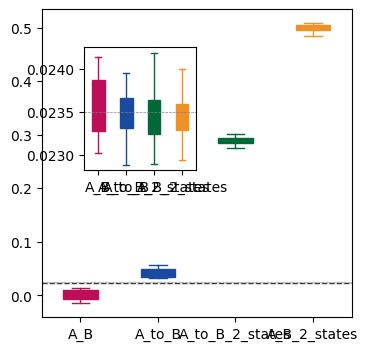

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Set matplotlib to use vector backend and disable clipping
plt.rcParams['svg.fonttype'] = 'none'  # Keep text as text, not paths
plt.rcParams['font.family'] = 'sans-serif'  # Use system fonts

sim_types_to_plot = ['A_B','A_to_B', 'A_to_B_2_states', 'A_B_2_states']
colors = ['#bc0f58', '#194a9e', '#006937', '#ee9127']

# Collect all iteration values for g1_g2 (equivalent to iloc[0,1])
all_values = []
all_thresholds = []

for sim_type in sim_types_to_plot:
    # Filter data for this simulation type
    sim_data = gene_gene_corr_data[gene_gene_corr_data['sim_type'] == sim_type]
    
    # Get g1_g2 values (change column name if different)
    vals = sim_data['g1_g2'].values.tolist()  # or whatever your gene pair column is
    thresholds = sim_data['threshold'].values.tolist()
    
    all_values.append(vals)
    all_thresholds.append(thresholds)

# Flatten thresholds for min/max calculation
flat_thresholds = [item for sublist in all_thresholds for item in sublist]

# --- Main boxplot for gene_gene values ---
fig, ax = plt.subplots(figsize=(4, 4))

# REMOVE ALL BACKGROUNDS
#figure_2_v3_2x_cells  # Figure background transparent
ax.set_facecolor('none')         # Axes background transparent

# Add fill_between BEFORE creating boxplot so it appears behind
x_range = np.arange(0.5, len(sim_types_to_plot) + 0.5, 0.01)  # Smooth x range
ax.fill_between(x_range, 
                np.min(flat_thresholds), 
                np.max(flat_thresholds), 
                alpha=0.2, 
                color="lightgray", 
                edgecolor="black", 
                linestyle="--", 
                linewidth=1,
                label="Threshold range")

# Add mean threshold line
ax.axhline(np.mean(flat_thresholds), 
          linestyle="--", 
          color="black", 
          linewidth=1, 
          alpha=0.7,
          label="Mean threshold")

# Create boxplot
box = ax.boxplot(all_values, tick_labels=sim_types_to_plot, patch_artist=True, showfliers=False)

# Style each component with matching color
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)

for whisker, color in zip(box['whiskers'], [c for c in colors for _ in (0, 1)]):
    whisker.set_color(color)

for cap, color in zip(box['caps'], [c for c in colors for _ in (0, 1)]):
    cap.set_color(color)

for median, color in zip(box['medians'], colors):
    median.set_color(color)
    median.set_linewidth(2)

# DISABLE CLIPPING for all elements (prevents masks in Illustrator)
for element_list in [box['boxes'], box['whiskers'], box['caps'], box['medians']]:
    for element in element_list:
        element.set_clip_on(False)

# --- Add inset plot for thresholds in the left white space ---
# Create inset axes positioned in the left area
inset_ax = inset_axes(ax, width="120%", height="80%", 
                      bbox_to_anchor=(0.22, 0.4, 0.3, 0.5),
                      bbox_transform=ax.transAxes)

# REMOVE INSET BACKGROUND
inset_ax.set_facecolor('none')

# Create threshold boxplot in inset
box_inset = inset_ax.boxplot(all_thresholds, tick_labels=sim_types_to_plot, 
                            patch_artist=True, showfliers=False)
inset_ax.axhline(np.mean(flat_thresholds), linestyle="--", color="grey", linewidth=0.5)

# Style inset boxplot with matching colors
for patch, color in zip(box_inset['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)

for whisker, color in zip(box_inset['whiskers'], [c for c in colors for _ in (0, 1)]):
    whisker.set_color(color)

for cap, color in zip(box_inset['caps'], [c for c in colors for _ in (0, 1)]):
    cap.set_color(color)

for median, color in zip(box_inset['medians'], colors):
    median.set_color(color)
    median.set_linewidth(2)

# DISABLE CLIPPING for inset elements too
for element_list in [box_inset['boxes'], box_inset['whiskers'], box_inset['caps'], box_inset['medians']]:
    for element in element_list:
        element.set_clip_on(False)

plt.savefig(f'{output_folder}/gene_gene_correlation.png', 
           format='png', 
           bbox_inches='tight',
           facecolor='none',      # Transparent figure background
           edgecolor='none',      # No edge color
           transparent=True)      # Ensure transparency

# Style main axes
# ax.tick_params(
#     axis='both',
#     which='both',
#     bottom=True, top=False, left=True, right=False,
#     labelbottom=False, labelleft=False,
#     length=4, width=1
# )

# Style inset axes
# inset_ax.tick_params(
#     axis='both',
#     which='both',
#     bottom=True, top=False, left=True, right=False,
#     labelbottom=False, labelleft=False,
#     length=2, width=0.5,
#     labelsize=6
# )

# REMOVE SPINES if you don't want axis borders
# Uncomment these lines if you want completely clean edges:
# for spine in ax.spines.values():
#     spine.set_visible(False)
# for spine in inset_ax.spines.values():
#     spine.set_visible(False)

# Save with transparent background and no clipping masks
plt.savefig(f'{output_folder}/gene_gene_correlation_with_label.png', 
           format='pdf', 
           bbox_inches='tight',
           facecolor='none',      # Transparent figure background
           edgecolor='none',      # No edge color
           transparent=True)      # Ensure transparency

plt.show()

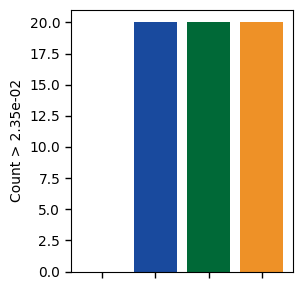

In [15]:
# Count how many values are greater than threshold for each sim_type
counts = []
for i, sim_type in enumerate(sim_types_to_plot):
    # Filter data for this simulation type
    sim_data = gene_gene_corr_data[gene_gene_corr_data['sim_type'] == sim_type]
    
    # Get the g1_g2 values (adjust column name if different)
    vals = sim_data['g1_g2'].values  # Change 'g1_g2' to your actual column name
    threshold = np.mean(all_thresholds[i])
    # Count values >= threshold
    count_greater = np.sum(vals >= threshold)
    counts.append(count_greater)
    
    # Print the values >= threshold
    all_values = vals[vals < threshold]

# Create bar plot
plt.figure(figsize=(3, 3))
bars = plt.bar(sim_types_to_plot, counts, color=colors)

plt.ylabel(f'Count > {threshold:.2e}')
plt.axhline(0, color='black', linewidth=0.5)

plt.tick_params(
    axis='both',
    which='both',
    bottom=True, top=False, left=True, right=False,
    labelbottom=False, labelleft=True,
    length=4, width=1
)

plt.tight_layout()
plt.savefig(f'{output_folder}/number_points_cross_gene_gene_threshold.png', format='png')
plt.show()

## Panel 2b - single vs multi-state


In [16]:
# Load the data
random_correlation_path = "/home/mzo5929/Keerthana/grnInference/plot_data/figure_2_t1_1h_t2_20h/random_matrix_results.csv"
twin_correlation_t1_path= "/home/mzo5929/Keerthana/grnInference/plot_data/figure_2_t1_1h_t2_20h/twin_t1_matrix_results.csv"
random_correlation_data = pd.read_csv(random_correlation_path)
twin_correlation_t1_data = pd.read_csv(twin_correlation_t1_path)

In [19]:
t1 = 1
t2 = 20
path_to_A_to_B = f"{data_folder}/A_to_B/df_rows_0_1_05082025_160041_ncells_6000_A_to_B_rep_0.csv"
random_correlation_A_to_B = get_many_random_pair_corr(
        path_to_A_to_B,
        base_config,
        t1, t2,
        check_for_steady_state=False,
        have_any_output=False,
        plot_correlation_matrices_as_heatmap=False
    )['all_values']

path_to_A_B_2_states = [f"{data_folder}/A_B_high_k_on/df_rows_3_3_09082025_201359_ncells_6000_A_B_high_k_on_rep_0.csv", f"{data_folder}/A_B_low_k_on/df_rows_2_2_09082025_210256_ncells_6000_A_B_low_k_on_rep_0.csv"]
random_correlation_A_B_2_states = get_many_random_pair_corr(
        path_to_A_B_2_states,
        base_config,
        t1, t2,
        check_for_steady_state=False,
        have_any_output=False,
        plot_correlation_matrices_as_heatmap=False
    )['all_values']

path_to_A_to_B_2_states = [f"{data_folder}/A_to_B_high_k_on/df_rows_3_3_09082025_220257_ncells_6000_A_to_B_high_k_on_rep_0.csv", f"{data_folder}/A_to_B_low_k_on/df_rows_2_2_09082025_212311_ncells_6000_A_to_B_low_k_on_rep_0.csv"]
random_correlation_A_to_B_2_states = get_many_random_pair_corr(
        path_to_A_to_B_2_states,
        base_config,
        t1, t2,
        check_for_steady_state=False,
        have_any_output=False,
        plot_correlation_matrices_as_heatmap=False
    )['all_values']

6000
(12000, 8)
(6000, 8) (6000, 8)
6000
(12000, 8)
(6000, 8) (6000, 8)
6000
(12000, 8)
(6000, 8) (6000, 8)


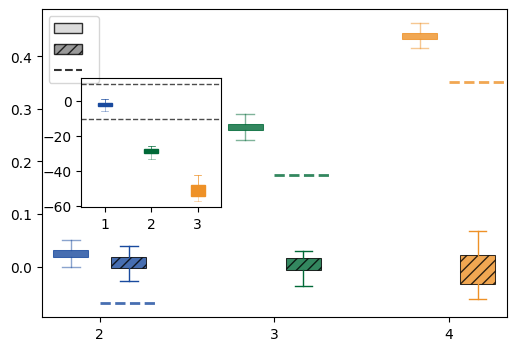

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Set matplotlib to use vector backend and disable clipping
plt.rcParams['svg.fonttype'] = 'none'  # Keep text as text, not paths
plt.rcParams['font.family'] = 'sans-serif'  # Use system fonts

# Load twin correlation data from CSV
twin_correlation_t1_path = "/home/mzo5929/Keerthana/grnInference/plot_data/figure_2_t1_1h_t2_20h/twin_t1_matrix_results.csv"
twin_correlation_t1_data = pd.read_csv(twin_correlation_t1_path)

# Define simulation types and colors
sim_types_to_plot = ['A_to_B', 'A_to_B_2_states', 'A_B_2_states']
colors = ['#194a9e', '#006937', '#ee9127']
light_colors = [color + '80' for color in colors]

# Your separate random correlation variables
random_correlation_data = [
    random_correlation_A_to_B,
    random_correlation_A_to_B_2_states,
    random_correlation_A_B_2_states
]

# Collect data for plotting
all_data = []
all_colors = []
positions = []
thresholds_1pct = []
z_scores = []

pos = 1
for i, sim_type in enumerate(sim_types_to_plot):
    
    # 1. Process random correlation data
    random_vals = np.array(random_correlation_data[i])
    random_vals = random_vals[~np.isnan(random_vals)]
    
    # 2. Get twin correlation data from CSV
    twin_sim = twin_correlation_t1_data[twin_correlation_t1_data['sim_type'] == sim_type]
    twin_vals = twin_sim['g1_g2'].values  # Adjust column name if needed
    
    if len(random_vals) > 0 and len(twin_vals) > 0:
        # Calculate 1st percentile threshold from random data
        threshold_1pct = np.percentile(random_vals, 0.01)
        thresholds_1pct.append(threshold_1pct)
        
        # Calculate z-score for the threshold
        # Z-score = (value - mean) / std_dev
        random_mean = np.mean(random_vals)
        random_std = np.std(random_vals)
        z_score = ((twin_vals) - random_mean) / random_std
        z_scores.append(z_score)
        
        # Add to plotting data (random first, then twin)
        all_data.extend([random_vals, twin_vals])
        all_colors.extend([light_colors[i], colors[i]])
        positions.extend([pos, pos + 1])       
        pos += 3  # Space between groups
    else:
        print(f"Warning: {sim_type} missing data - Random: {len(random_vals)}, Twin: {len(twin_vals)}")

# Create Plot 1: Twin vs Random boxplots (MAIN FIGURE)
if len(all_data) > 0:
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # REMOVE ALL BACKGROUNDS
    #figure_2_v3_2x_cells  # Figure background transparent
    ax.set_facecolor('none')         # Axes background transparent

    # Create boxplot with different styles
    box = ax.boxplot(all_data, positions=positions, patch_artist=True, showfliers=False, widths=0.6)  # Removed showmedians
    # BEGIN: Remove median lines from boxplot
    for median in box['medians']:
        median.set_visible(False)
    # END: Remove median lines from boxplot
    # Color and style the boxes differently for random vs twin
    for i, (patch, color) in enumerate(zip(box['boxes'], all_colors)):
        if i % 2 == 0:  # Random boxes (even indices)
            patch.set_facecolor(color)
            patch.set_edgecolor(color)
            patch.set_linewidth(0.75)
            patch.set_alpha(0.8)
        else:  # Twin boxes (odd indices)
            patch.set_facecolor(color)
            patch.set_edgecolor('black')  # Black outline
            patch.set_linewidth(0.75)
            hatch = '///'  # Define the hatch pattern
            patch.set_hatch(hatch)  # Hatching for twin boxes
            patch.set_linestyle('-')   # Solid outline for twin
            patch.set_alpha(0.8)
        # DISABLE CLIPPING for Illustrator compatibility
        patch.set_clip_on(False)

    # Style whiskers, caps, and medians differently
    for i, whisker in enumerate(box['whiskers']):
        whisker.set_color(all_colors[i//2])
        whisker.set_linewidth(1)
        whisker.set_clip_on(False)
        if (i // 2) % 2 == 0:  # Random whiskers
            whisker.set_linestyle('-')
        else:  # Twin whiskers
            whisker.set_linestyle('-')

    for i, cap in enumerate(box['caps']):
        cap.set_color(all_colors[i//2])
        cap.set_linewidth(1)
        cap.set_clip_on(False)
        if (i // 2) % 2 == 0:  # Random caps
            cap.set_linestyle('-')
        else:  # Twin caps
            cap.set_linestyle('-')

    # for i, median in enumerate(box['medians']):
    #     median.set_color(colors[i//2])
    #     median.set_linewidth(3)
    #     median.set_clip_on(False)
    #     if i % 2 == 0:  # Random medians
    #         median.set_linestyle('-')
    #     else:  # Twin medians
    #         median.set_linestyle('-')

    # Add z-score = 10 threshold lines for each group
    z_score_threshold = -10
    group_x_ranges = [(0.5, 2.5), (3.5, 5.5), (6.5, 8.5)]  # x-ranges for each group
    for i, (x_start, x_end) in enumerate(group_x_ranges):
        if i < len(thresholds_1pct):
            # Calculate where z-score = 10 would be for each group
            random_mean = np.mean(all_data[i*2])  # Random data for this group
            random_std = np.std(all_data[i*2])
            z_10_threshold = random_mean + (z_score_threshold * random_std)
            
            ax.hlines(z_10_threshold, x_start+1, x_end, 
                     colors=colors[i], linestyles='--', linewidth=2, alpha=0.8)
            # Add text label for z-score = 10
            # ax.text(x_end + 0.1, z_10_threshold, f'z-score = {z_score_threshold}', 
            #        fontsize=24, va='center', color=colors[i], weight='bold')

    # Set x-axis labels
    group_centers = [1.5, 4.5, 7.5]  # Centers of each pair
    ax.set_xticks(group_centers)
    ax.set_xticklabels([2, 3, 4])

    # Add legend with different styles
    legend_elements = [
        Patch(facecolor='lightgray', edgecolor='black', linestyle='-',
              alpha=0.8),
        Patch(facecolor='gray', edgecolor='black', linestyle='-',
              alpha=0.8, hatch='///'),
        Line2D([0], [0], color='black', linestyle='--', alpha=0.8)
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

    # Clean styling for Illustrator
    ax.set_ylabel('')
    ax.set_title('')
    
    # --- ADD Z-SCORE INSET ---
    # Create inset for z-scores in upper left corner
    z_inset_ax = inset_axes(ax, width="50%", height="70%", 
                           bbox_to_anchor=(-0.2, 0.2, 0.6, 0.6),
                           bbox_transform=ax.transAxes)
    
    # REMOVE Z-SCORE INSET BACKGROUND
    z_inset_ax.set_facecolor('none')
    
    # Create z-score boxplot
    z_box = z_inset_ax.boxplot(z_scores, patch_artist=True, showfliers=False)
    for i, median in enumerate(z_box['medians']):
        median.set_color(colors[i])
        median.set_linewidth(1)
        median.set_clip_on(False)

    for i, whisker in enumerate(z_box['whiskers']):
        whisker.set_color(all_colors[i])
        whisker.set_linewidth(0.5)
        whisker.set_clip_on(False)


    for i, cap in enumerate(z_box['caps']):
        cap.set_color(all_colors[i])
        cap.set_linewidth(0.5)
        cap.set_clip_on(False)

    # Add z-score thresholds
    z_inset_ax.axhline(-1*z_score_threshold, linestyle="--", color="black", linewidth=1, alpha=0.7, label="z-score threshold")
    z_inset_ax.axhline(z_score_threshold, linestyle="--", color="black", linewidth=1, alpha=0.7)
    
    # # Add threshold text
    # z_inset_ax.text(3, -1*z_score_threshold, f'z-score threshold = {z_score_threshold}', 
    #                verticalalignment='top', horizontalalignment='right', fontsize=12)
    
    # Style z-score boxplot with matching colors
    for i, patch in enumerate(z_box['boxes']):
        patch.set_facecolor(colors[i])
        patch.set_edgecolor(colors[i])
        patch.set_clip_on(False)
    
    # Disable clipping for all z-score elements
    for element_list in [z_box['boxes'], z_box['whiskers'], z_box['caps'], z_box['medians']]:
        for element in element_list:
            element.set_clip_on(False)
    
    # Set z-score labels
    z_inset_ax.set_xticks([1,2,3])
    # z_inset_ax.set_xticklabels(["A->B, single-state", "A,B, multi-state", "A->B, multi-state"], 
    #                           fontsize=10, rotation=45, ha='right')
    # z_inset_ax.set_ylabel("Z-score", fontsize=12)
    z_inset_ax.tick_params(labelsize=10)
    # z_inset_ax.legend(fontsize=10)
    plt.savefig(f"{output_folder}/twin_correlation_with_zscore_inset.png", 
               format="png", 
               bbox_inches='tight',
               facecolor='none',      # Transparent figure background
               edgecolor='none',      # No edge color
               transparent=True)      # Ensure transparency

    # ax.tick_params(
    #         axis='both',
    #         which='both',
    #         bottom=True, top=False, left=True, right=False,
    #         labelbottom=False, labelleft=False,
    #         length=2, width=0.5,
    #         labelsize=6
    #     )


    # z_inset_ax.tick_params(
    #     axis='both',
    #     which='both',
    #     bottom=True, top=False, left=True, right=False,
    #     labelbottom=False, labelleft=False,
    #     length=2, width=0.5,
    #     labelsize=6
    # )

    # Save with Illustrator-friendly settings
    # plt.savefig(f"{output_folder}/twin_correlation_with_zscore_inset.pdf", 
    #            format="pdf", 
    #            bbox_inches='tight',
    #            facecolor='none',      # Transparent figure background
    #            edgecolor='none',      # No edge color
    #            transparent=True)      # Ensure transparency
    
    plt.show()
else:
    print("No valid data available for plotting!")

In [3]:
twin_correlation_t1_path = "/home/mzo5929/Keerthana/grnInference/plot_data/figure_2_t1_1h_t2_20h/twin_t1_matrix_results.csv"
twin_correlation_t1_data = pd.read_csv(twin_correlation_t1_path)
twin_correlation_t2_path = "/home/mzo5929/Keerthana/grnInference/plot_data/figure_2_t1_1h_t2_20h/twin_t2_matrix_results.csv"
twin_correlation_t2_data = pd.read_csv(twin_correlation_t2_path)

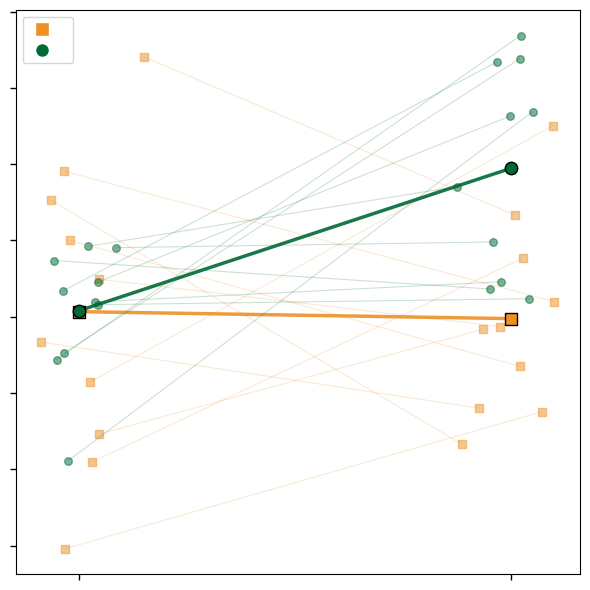

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import wilcoxon, ttest_rel


# Set matplotlib to use vector backend and disable clipping
plt.rcParams['svg.fonttype'] = 'none'  # Keep text as text, not paths
plt.rcParams['font.family'] = 'sans-serif'  # Use system fonts

sim_types_to_plot = ['A_B_2_states', 'A_to_B_2_states']
colors = ['#ed9126', '#006935']
markers = ["s", "o"]
fig, ax = plt.subplots(figsize=(6, 6))

# REMOVE ALL BACKGROUNDS
#figure_2_v3_2x_cells  # Figure background transparent
ax.set_facecolor('none')         # Axes background transparent

x_positions = {'t1': 0.2, 't2': 0.8}  # shift away from the edges
mean_points = {}
differences = []

# Store legend handles
legend_handles = []

for i, (sim_type, color, marker) in enumerate(zip(sim_types_to_plot, colors, markers)):
    # Get data from CSV files
    t1_sim_data = twin_correlation_t1_data[twin_correlation_t1_data['sim_type'] == sim_type]
    t2_sim_data = twin_correlation_t2_data[twin_correlation_t2_data['sim_type'] == sim_type]
    
    t1_vals = (t1_sim_data['g1_g2'].values)[:10]  # Adjust column name if needed
    t2_vals = (t2_sim_data['g1_g2'].values)[:10]  # Adjust column name if needed
    differences = list(t2_vals - t1_vals) 
    mean = np.mean(differences)
    std_dev = np.std(differences)
    # --- Perform Wilcoxon signed-rank test ---
    stat, p_value = wilcoxon(t1_vals, t2_vals)
    
    # Format p-value
    p_text = f"p = {p_value:.4f}"
    

    # --- Jittered strip plot ---
    jitter_t1 = np.random.normal(x_positions['t1'], 0.03, size=len(t1_vals))
    jitter_t2 = np.random.normal(x_positions['t2'], 0.03, size=len(t2_vals))

    scatter1 = ax.scatter(jitter_t1, t1_vals, color=color, alpha=0.5, s=30, marker = marker)
    scatter2 = ax.scatter(jitter_t2, t2_vals, color=color, alpha=0.5, s=30, marker = marker)
    
    # DISABLE CLIPPING for scatter plots
    scatter1.set_clip_on(False)
    scatter2.set_clip_on(False)

    # --- Light individual connection lines ---
    for x1, y1, x2, y2 in zip(jitter_t1, t1_vals, jitter_t2, t2_vals):
        line = ax.plot([x1, x2], [y1, y2], color=color, alpha=0.2, linewidth=0.8)[0]
        line.set_clip_on(False)

    # --- Mean connection ---
    mean_t1, mean_t2 = np.mean(t1_vals), np.mean(t2_vals)
    mean_points[sim_type] = (mean_t1, mean_t2)

    mean_line = ax.plot(
        [x_positions['t1'], x_positions['t2']],
        [mean_t1, mean_t2],
        color=color,
        linewidth=2.5,
        alpha=0.9
    )[0]

    mean_line.set_clip_on(False)
    
    mean_scatter = ax.scatter(
        [x_positions['t1'], x_positions['t2']],
        [mean_t1, mean_t2],
        color=color,
        s=80,
        edgecolor='black',
        zorder=3,
        marker = marker,
        # label=f"{sim_type} mean"
    )
    mean_scatter.set_clip_on(False)
    
    # Store legend handle (using the mean scatter plot for cleaner legend)
    legend_handles.append(plt.Line2D([0], [0], marker=marker, color='w', 
                                   markerfacecolor=color, markersize=10, 
                                   linewidth=0))
    
    # --- Add p-value text above the mean line ---
    # Position text above the higher of the two mean points
    text_y = max(mean_t1, mean_t2) + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05 * (i + 1)
    text_x = np.mean([x_positions['t1'], x_positions['t2']])
    
    # ax.text(text_x, text_y, p_text, 
    #        color=color, 
    #        fontsize=12, 
    #        fontweight='bold',
    #        ha='center', 
    #        va='bottom')

# Add legend with no text labels
ax.legend(legend_handles, ['', ''], loc='upper left', frameon=True)

# --- Aesthetics ---
ax.set_xticks([x_positions['t1'], x_positions['t2']])
ax.set_xticklabels(['t1', 't2'])
ax.set_ylabel("")
# ax.set_title("t1 = 1h, t2= 20h, Wilcoxon test")
# ax.grid(True, axis='y', alpha=0.3)

# Style tick parameters for clean look
ax.tick_params(
    axis='both',
    which='both',
    bottom=True, top=False, left=True, right=False,
    labelbottom=False, labelleft=False,  # Hides tick labels
    length=4, width=1
)
ax.grid(False)  # Remove grid lines for final version

plt.tight_layout()

# Save with Illustrator-friendly settings
plt.savefig(f"{output_folder}/change_in_twin_correlation.pdf", 
           format="pdf",
           bbox_inches='tight',
           facecolor='none',      # Transparent figure background
           edgecolor='none',      # No edge color
           transparent=True)      # Ensure transparency
plt.show()